### The purpose of this notebook is to perform exploratory data analysis on the data

The data set is composed of tweets and an associated tag classifying their sentiment  
which ranges from negative, neutral to positive

In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
import os

In [45]:
tweet_df = pd.read_excel('data/LabeledText.xlsx')
tweet_df.head()

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive


Let's start by checking if there are any missing or duplicated values,  
then move onto the data types of each column, the total amount of rows,  
and then checking for any class imbalances

In [46]:
tweet_df.isnull().sum()

File Name    0
Caption      0
LABEL        0
dtype: int64

In [47]:
tweet_df.duplicated().sum()

0

In [48]:
tweet_df.dtypes

File Name    object
Caption      object
LABEL        object
dtype: object

In [49]:
tweet_df.shape

(4869, 3)

In [50]:
neutral_count = tweet_df[tweet_df['LABEL'] == 'neutral'].shape[0]
negative_count = tweet_df[tweet_df['LABEL'] == 'negative'].shape[0]
positive_count = tweet_df[tweet_df['LABEL'] == 'positive'].shape[0]
total_count = tweet_df.shape[0]

print(f'Negative Percentage:{round(negative_count/total_count*100)}%' +
      f'\nNeutral Percentage:{round(neutral_count/total_count*100)}%'+ 
      f'\nPositive Percentage:{round(positive_count/total_count*100)}%')

Negative Percentage:30%
Neutral Percentage:36%
Positive Percentage:34%


Each class looks to be fairly represented in the dataset,  
which means we won't have to do any upsampling or downsampling  
in order for our model to generalize

Since all we want is to learn how to predict the label  
for a given tweet, we only need to keep the caption and  
label column

In [51]:
tweet_df = tweet_df.drop(columns=['File Name'],axis=1)

In [52]:
print(f'Unique Labels:{tweet_df.LABEL.nunique()}')

Unique Labels:3


We see that we have the correct amount of class labels,  
let's move onto cleaning our tweets up, we'll have to remove  
any links, html tags, or non alphanumeric characters 

In [53]:
tweet_df['Caption'] = tweet_df['Caption'].str.replace(r'<[^<>]*>', '', regex=True)
tweet_df['Caption'] = tweet_df['Caption'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)

tweet_df.head()

,Caption,LABEL
0,How I feel today legday jelly aching gym,negative
1,ArrivaTW absolute disgrace two carriages from ...,negative
2,This is my Valentines from 1 of my nephews I a...,positive
3,betterfeelingfilms RT via Instagram First day ...,neutral
4,Zoes first love Rattled JohnnyHarper15,positive


In [54]:
tweet_df = tweet_df.rename(columns={'Caption':'tweets','LABEL':'labels'})
tweet_df.head()

,tweets,labels
0,How I feel today legday jelly aching gym,negative
1,ArrivaTW absolute disgrace two carriages from ...,negative
2,This is my Valentines from 1 of my nephews I a...,positive
3,betterfeelingfilms RT via Instagram First day ...,neutral
4,Zoes first love Rattled JohnnyHarper15,positive


Let's convert our labels from strings to categorical variables using label encoding

In [57]:
from sklearn.preprocessing import LabelEncoder

l_enc = LabelEncoder()
tweet_df['labels'] = l_enc.fit_transform(tweet_df['labels'])
tweet_df.head()

,tweets,labels
0,How I feel today legday jelly aching gym,0
1,ArrivaTW absolute disgrace two carriages from ...,0
2,This is my Valentines from 1 of my nephews I a...,2
3,betterfeelingfilms RT via Instagram First day ...,1
4,Zoes first love Rattled JohnnyHarper15,2


We'll now move onto tokenizing and padding our tweets

In [13]:
import tensorflow as tf

tf.random.set_seed(42)

tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fits the tweets to the tokenizer to update our vocabulary
tokenizer.fit_on_texts(tweet_df['tweets'])
# retreiving the text sequences so we can later pad them to all have equal length
text_sequences = tokenizer.texts_to_sequences(tweet_df['tweets'])

In [14]:
text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences)
len_seq = len(text_sequences[0])
num_seq = len(text_sequences)

In [15]:
# accessing our vocabulary
word2idx = tokenizer.word_index
idx2word = {v:w for w,v in word2idx.items()}
word2idx['PAD'] = 0
idx2word[0] = 'PAD'

Now that we've tokenized and padded our tweets we can move on to creating our datasets 

In [58]:
sentiment_labels = tf.keras.utils.to_categorical(tweet_df['labels'],num_classes=3)

In [60]:
dataset = tf.data.Dataset.from_tensor_slices((text_sequences,sentiment_labels))
dataset = dataset.shuffle(99999)

test_size = num_seq // 4
val_size = (num_seq - test_size) // 10

test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)

We now have to create our embedding matrix, to do so we'll be using GloVe to obtain  
our word embeddings, and then appeneding the embeddings to our embedding matrix

In [17]:
import gensim.downloader as api

EMBEDDING_DIM = 300
DATA_DIR = 'embed_data'
EMBEDDING_NP_FILE = os.path.join(DATA_DIR, 'E.npz')
EMBEDDING_MODEL = 'glove-wiki-gigaword-300'

In [18]:
def build_embedding_matrix(sequences,word2idx,dim,file):
    if os.path.exists(file):
        E = np.load(file)
    else:
        vocab_size = len(word2idx)
        E = np.zeros(shape=(vocab_size,dim))
        word_vectors = api.load(EMBEDDING_MODEL)
        for word, idx in word2idx.items():
            try:
                E[idx] = word_vectors.get_vector(word)
            except KeyError:
                pass
        np.save(EMBEDDING_NP_FILE,E)
    return E

In [19]:
E = build_embedding_matrix(text_sequences,word2idx,EMBEDDING_DIM,EMBEDDING_NP_FILE)
E.shape

(18266, 300)

We can now move onto creating our model

In [64]:
input_ = tf.keras.layers.Input(shape=len_seq)
embed_layer = tf.keras.layers.Embedding(len(word2idx),
                                        EMBEDDING_DIM,
                                        input_length=len_seq,
                                        weights = [E],
                                        trainable=False)(input_)
conv_layer1 = tf.keras.layers.Conv1D(filters=64,kernel_size=3,activation='relu')(embed_layer)
pool_layer1 = tf.keras.layers.MaxPool1D()(conv_layer1)
conv_layer2 = tf.keras.layers.Conv1D(filters=32,kernel_size=3,activation='relu')(pool_layer1)
pool_layer2 = tf.keras.layers.MaxPool1D()(conv_layer2)
flat_layer = tf.keras.layers.Flatten()(pool_layer2)
out = tf.keras.layers.Dense(units=3,activation='softmax')(flat_layer)

model = tf.keras.models.Model(inputs=input_,outputs=out)

In [65]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 29)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 29, 300)           5479800   
                                                                 
 conv1d_7 (Conv1D)           (None, 27, 64)            57664     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 11, 32)            6176      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 5, 32)            0         
 1D)                                                       

In [66]:
model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [67]:
history = model.fit(train_dataset,validation_data=val_dataset,
                    epochs=50,callbacks=[es])

Epoch 1/50
102/102 [==============================] - 2s 12ms/step - loss: 1.0346 - accuracy: 0.4807 - val_loss: 0.8997 - val_accuracy: 0.6222
Epoch 2/50
102/102 [==============================] - 1s 9ms/step - loss: 0.8400 - accuracy: 0.6437 - val_loss: 0.7046 - val_accuracy: 0.7358
Epoch 3/50
102/102 [==============================] - 1s 9ms/step - loss: 0.6889 - accuracy: 0.7200 - val_loss: 0.5310 - val_accuracy: 0.8210
Epoch 4/50
102/102 [==============================] - 1s 9ms/step - loss: 0.5651 - accuracy: 0.7800 - val_loss: 0.4343 - val_accuracy: 0.8494
Epoch 5/50
102/102 [==============================] - 1s 9ms/step - loss: 0.4836 - accuracy: 0.8244 - val_loss: 0.3646 - val_accuracy: 0.8807
Epoch 6/50
102/102 [==============================] - 1s 9ms/step - loss: 0.3900 - accuracy: 0.8692 - val_loss: 0.3586 - val_accuracy: 0.8778
Epoch 7/50
102/102 [==============================] - 1s 9ms/step - loss: 0.3113 - accuracy: 0.9010 - val_loss: 0.2561 - val_accuracy: 0.9205
Epoch

<Axes: >

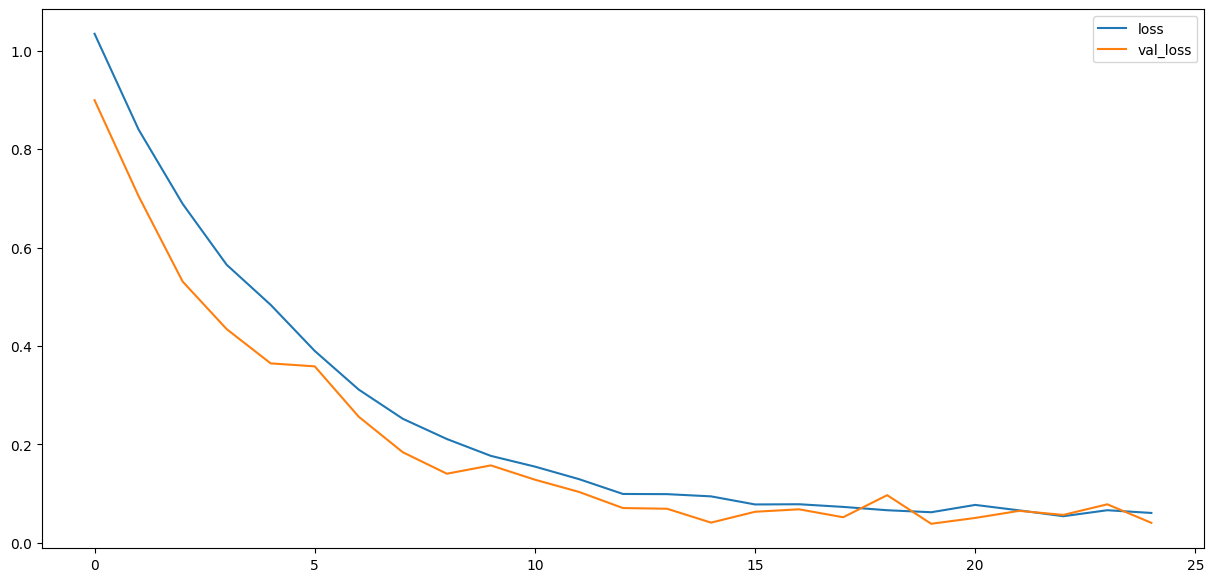

In [70]:
history_df = pd.DataFrame(history.history)

history_df[['loss','val_loss']].plot(figsize=(15,7))

<Axes: >

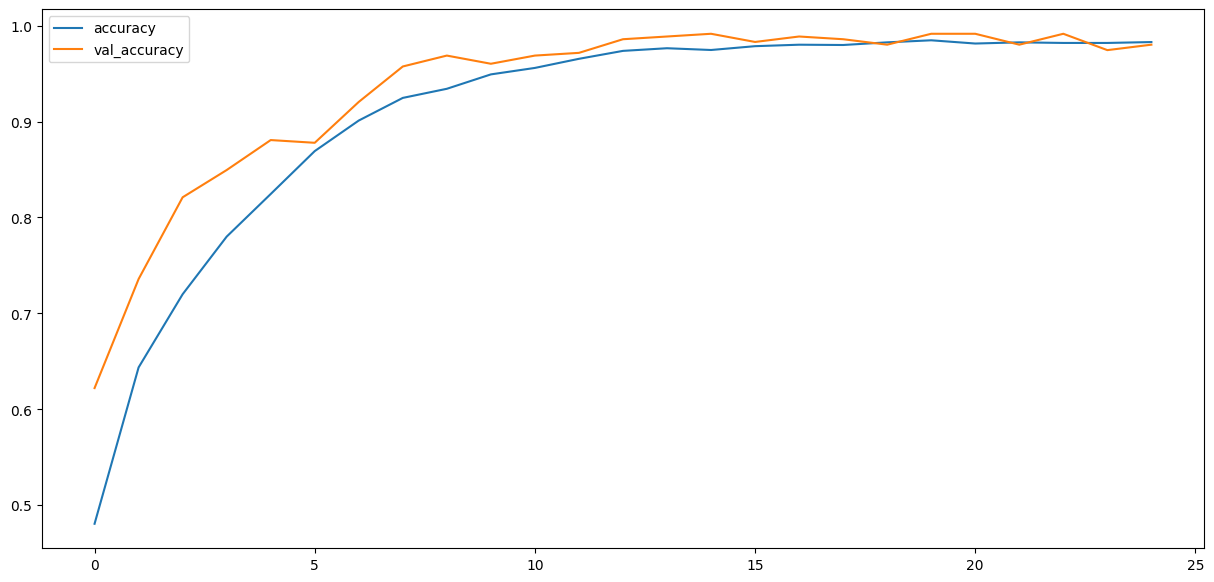

In [71]:
history_df[['accuracy','val_accuracy']].plot(figsize=(15,7))

As we can see, the model doesn't seem to be over or underfitting our data, it performs very well  
on the training and validation sets, lets see how it does on the test set

In [74]:
model.evaluate(test_dataset)

38/38 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9753


[0.07295852154493332, 0.9753289222717285]

The accuracy on the test set is quite high, however this does not tell the full story,  
let's take a look at the confusion matrix

153/153 [==============================] - 1s 4ms/step


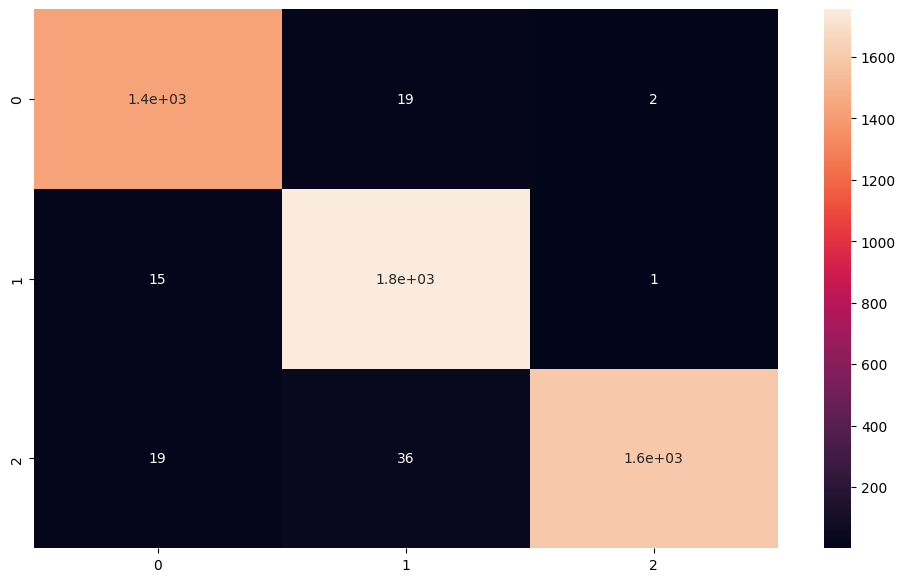

In [88]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

X_test, y_test = tuple(zip(*dataset))
X_test = np.array(X_test)
y_test = np.array(y_test)

y_test = np.argmax(y_test,axis=-1)
y_preds = np.argmax(model.predict(X_test),axis=-1)

cnf_mtx = confusion_matrix(y_test,y_preds)

plt.figure(figsize=(12,7))
sns.heatmap(cnf_mtx,annot=True)
plt.show()

The model looks to be predicting each of the labels quite well